# Mutual information to determine regulons associated with fates

In [7]:
import numpy as np
import pandas as pd
import pandas
import anndata
#import ipywidgets as widgets
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
from matplotlib import rc_context
import math
import os
import scanpy as sc
from scipy import stats, interpolate
from scipy.interpolate import make_interp_spline, BSpline
from sklearn import linear_model, preprocessing, model_selection, feature_selection
#from kneed import KneeLocator
import itertools

In [8]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['pdf.fonttype'] = 42

## Below you can select alternate fate datasets, last number corresponds with number of days into differentiation fate probabilities are predicting

Note: The days below are only including adata from days 5 and 10 - not the rest of the adata  - both EHT and LBC are included

In [11]:
# NEED TO DETERMINE WHAT DAY THE FATES ARE FOR - ASSUME DAY 10
FATES_PATH_NEW_GR = './adata/lot_mt_all_integrated-update.h5ad'
REGS_PATH = './regs/bc-tb-aucell-reordered-index-proper.csv'
ADATA_PATH = "./adata/LBC-EHT-sep-reg-ccreg-ct-update-sigs-added-index-proper.h5ad"
TRENDS_PATH = './trends/wot-lot-combine/'
REGS_TRENDS_PATH = "./trends-regs/wot-lot-combine-regs/"
TMAP_PATH = './tmaps/wot-lot-combine/'

In [12]:
df = sc.read(FATES_PATH_NEW_GR).to_df()

# Functions below for running mi pipeline

In [13]:
def create_fates_df_and_adata_for_ct_day5(fp: str, ct: str, adata_path):
    fates = anndata.read_h5ad(fp)
    fates = fates[fates.obs['Order']==5]
    if ct in fates.var_names:
        end_point = fp.split('_')[1].split('Fate')[0]
        print('Endpoint: ', end_point)
        adata = sc.read_h5ad(adata_path)
        adata = adata[adata.obs_names.isin(fates.obs_names)]
        fates_df = pd.DataFrame(fates.X, index=fates.obs_names, columns=fates.var_names)
        fates_df = fates_df[[ct]]
        key = ct+' : '+end_point
        adata.obs[key] = fates_df[ct]
        sc.pl.umap(adata, color=key, s=4)

        # Plot Fates distribution
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        ax[0].hist(fates_df[ct], color='black', bins=[x/100 for x in range(0, 105, 5)])
        ax[0].set_xlabel(ct+":"+str(end_point)+' Fate Probability')
        ax[0].set_title(ct+":"+str(end_point)+' Fate Probability')
        ax[1].hist(fates_df[ct], color='black', bins=[x/100 for x in range(5, 105, 5)])
        ax[1].set_xlabel(ct+":"+str(end_point)+' Fate Probability - No Zero')
        ax[1].set_title(ct+":"+str(end_point)+' Fate Probability - No Zero')
        plt.show()
        return adata, fates, fates_df

In [14]:
def plot_fate_distributions_for_each_endpoint(adata_path, fates_list):
    adata = sc.read_h5ad(adata_path)
    sc.pl.umap(adata, color='Cell Types')
    for q in list(set(adata.obs['Cell Types'])):
        print('====================================================================================')
        print(q)
        for fp in fates_list:
            create_fates_df_and_adata_for_ct(fp, q, adata_path)

In [15]:
def create_df_for_mutual_info(regulons_path, fates_path):
    df = sc.read(fates_path)
    df = df.to_df()
    regulons = pd.read_csv(regulons_path, index_col=0)
    regulons = regulons[regulons.index.isin(df.index)]
    for x in regulons.columns:
        df[x] = regulons[x]
    return df

In [16]:
# We need to discretize the fates
def discretize_fates(df, n_bins:int): # dataframe needs to have fate probabilties labelled by cell type
    for x in df.columns:
        if x.endswith('Cells'):
            highest_fate_prob=max(df[x])
            multi_val = highest_fate_prob / n_bins
            bins = [round(x*multi_val, 2) for x in range(n_bins)]
            ls = np.digitize(df[x], bins=bins)
            df[x] = [str(round(x/n_bins, 2)) for x in ls]
    return df

In [17]:
# compute mutual information
def mutual_info_fates(df):
    m_info_dict = {}
    for x in df.columns:
        if x.endswith('Cells'):
            # Train test split to avoid overfitting
            X_train, X_test, y_train, y_test=model_selection.train_test_split(df.drop(labels=[y for y in df.columns if y.endswith('Cells')], axis=1),
                                                                             df[x], test_size=0.3, random_state=0)
            # determine mutual information
            mutual_info = feature_selection.mutual_info_classif(X_train, y_train)
            mutual_info = pd.Series(mutual_info)
            mutual_info.index = X_train.columns
            m_info_dict[x] = mutual_info

    m_df = pd.DataFrame.from_dict(m_info_dict, orient='index').transpose()
    return m_df

In [18]:
def plot_fate_distributions_for_each_endpoint_T1_cells(adata_path, fp):
    adata = sc.read_h5ad(adata_path)
    adata = adata[adata.obs['Order']==5]
    sc.pl.umap(adata, color='Cell Types')
    for q in list(set(adata.obs['Cell Types'])):
        print('====================================================================================')
        print(q)
        create_fates_df_and_adata_for_ct_day5(fp, q, adata_path)

In [19]:
def plot_mi(fates_path, raw_df, discretized_df, mi_df, num_regs=15, fontsize=8, save=False):
    df = sc.read(fates_path).to_df()
    color_map='plasma'
    for x in mi_df.columns:
        mi_df = mi_df.sort_values(by=x, ascending=False)[0:num_regs]
        print(mi_df)
        ls = [x]+list(mi_df.sort_values(by=x, ascending=False).index)
        print(ls)
        
        # Make heatmap
        tmp = raw_df[ls].sort_values(by=x)
        s = len(tmp.columns) / 16
        x_1 = tmp.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x_1)
        df_scaled = pd.DataFrame(x_scaled, columns=tmp.columns, index=tmp.index)
        X = range(0, len(df_scaled.index))
        y = df_scaled.drop(x, axis=1).values
        reg = linear_model.LinearRegression().fit(y, X)
        ro_ls = []
        ro_ls1 = []
        columns = list(df_scaled.drop(x, axis=1).columns)
        print(reg.coef_)
        for i, y in enumerate(reg.coef_):
            if y<0:
                ro_ls1.append(columns[i])
            else:
                ro_ls.append(columns[i])
        ro_cols = [x] + ro_ls + ro_ls1
        print(df_scaled.columns)
        df_scaled = df_scaled[ro_cols]
        print(df_scaled.columns)
        with rc_context({'figure.figsize': (5.5, 5)}):
            _, ax = plt.subplots(figsize=(2 * 4, s * 6))
            img = ax.imshow(
                np.array(df_scaled.T.values),
                aspect='auto',
                interpolation='nearest',
                cmap=color_map,
            )
            plt.colorbar(img, shrink=0.5)
            plt.yticks(range(tmp.T.shape[0]),
                       [x]+[z.split('(')[0]+' : '+str(round(mi_df[x][z], 2)) for z in ls if z.endswith('(+)')],
                       fontsize=fontsize)
            plt.ylabel('Regulons : MI with CT')
            plt.xlabel(x+' Fate Probability')
            if save:
                plt.savefig(save, transparent=True)
            plt.show()

#             # + plot of means of reg activity at each bin
#             tmp1 = discretized_df[ls].sort_values(by=x)
#             plot_df = tmp1.groupby([x]).mean()
#             width=0.4
#             for y in ls:
#                 if y.endswith('(+)'):
#                     plt.bar(x=plot_df.index,
#                             height=list(plot_df[y]), width=width, align="center",
#                             tick_label=plot_df.index)
#                     plt.xlabel(x+' Fate Probability (Right Bin Threshold)')
#                     plt.ylabel('Mean '+y+' Activity')
#                     plt.show()

In [20]:
def run_mi_pipeline(regulons_path, fates_path, n_bins=10, num_regs=15, fontsize=8):
    df = create_df_for_mutual_info(regulons_path, fates_path)
    df1 = discretize_fates(df.copy(), n_bins=n_bins)
    mi_df = mutual_info_fates(df1)
    plot_mi(fates_path, df, df1, mi_df, num_regs=num_regs, fontsize=fontsize)
    return mi_df, df, df1

def run_mi_pipeline_T1(regulons_path, fates_path, n_bins=10, num_regs=15, fontsize=8):
    df = create_df_for_mutual_info(regulons_path, fates_path)
    df1 = discretize_fates(df.copy(), n_bins=n_bins)
    mi_df = mutual_info_fates(df1)
    plot_mi(fates_path, df, df1, mi_df, num_regs=num_regs, fontsize=fontsize)
    return mi_df, df, df1

C:\Users\mattc\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\mattc\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


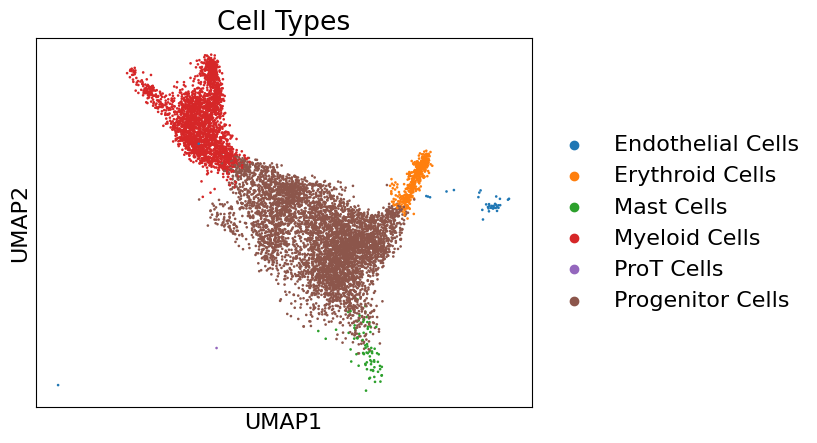

Myeloid Cells
Endpoint:  mt


C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\3433665326.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key] = fates_df[ct]


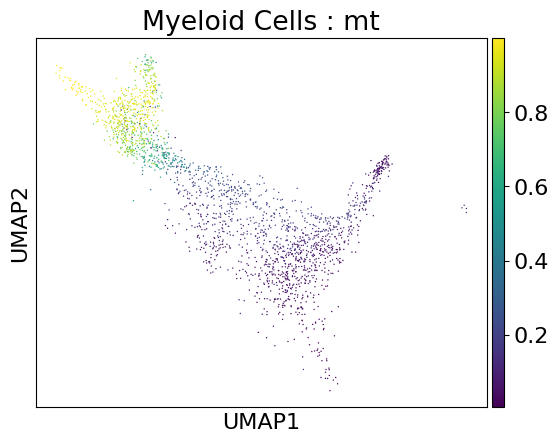

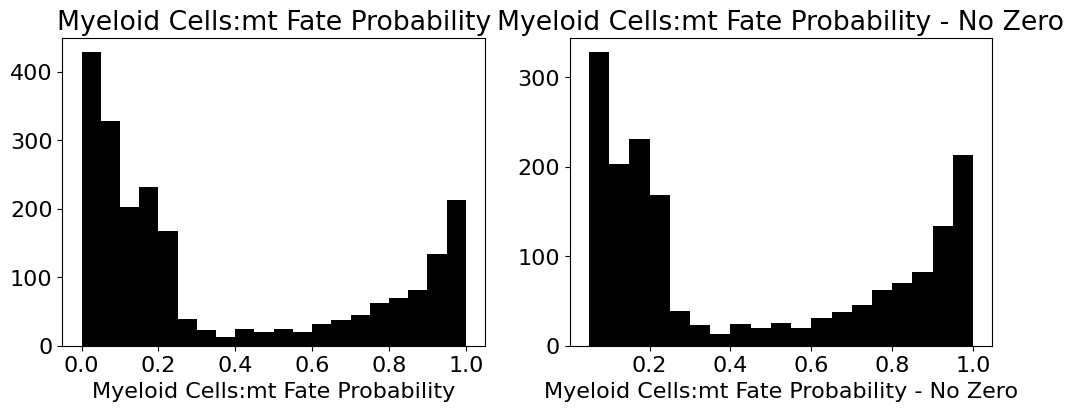

Progenitor Cells
Endpoint:  mt


C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\3433665326.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key] = fates_df[ct]


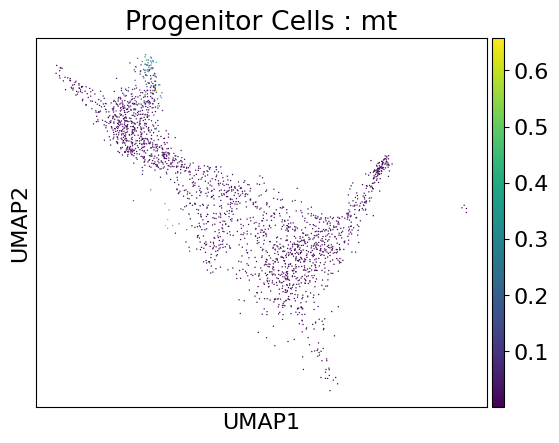

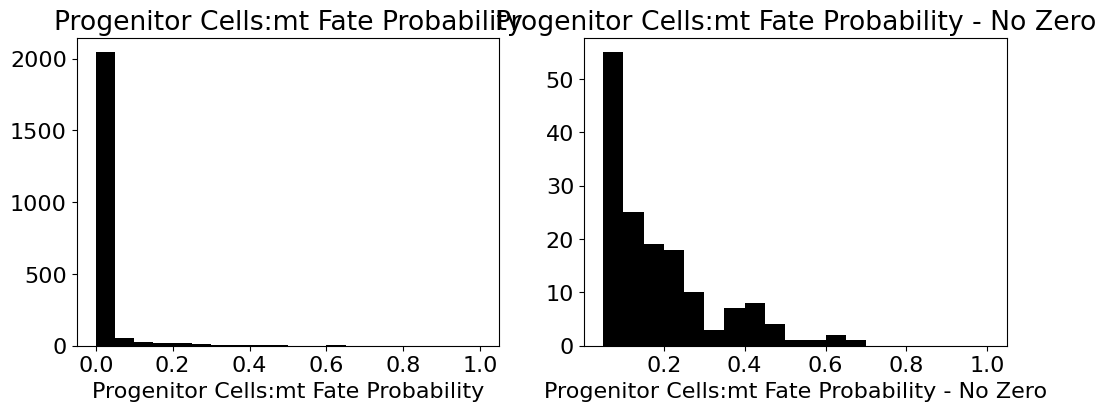

Endothelial Cells
ProT Cells
Endpoint:  mt


C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\3433665326.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key] = fates_df[ct]


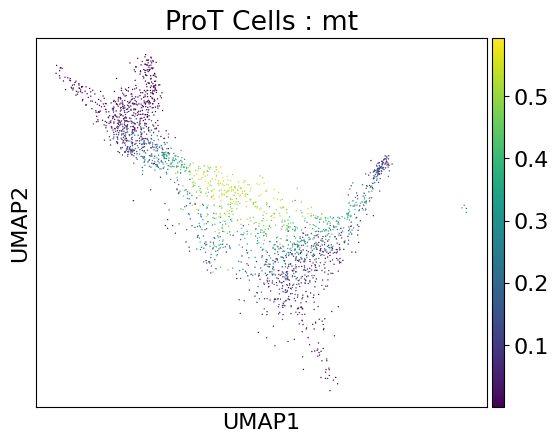

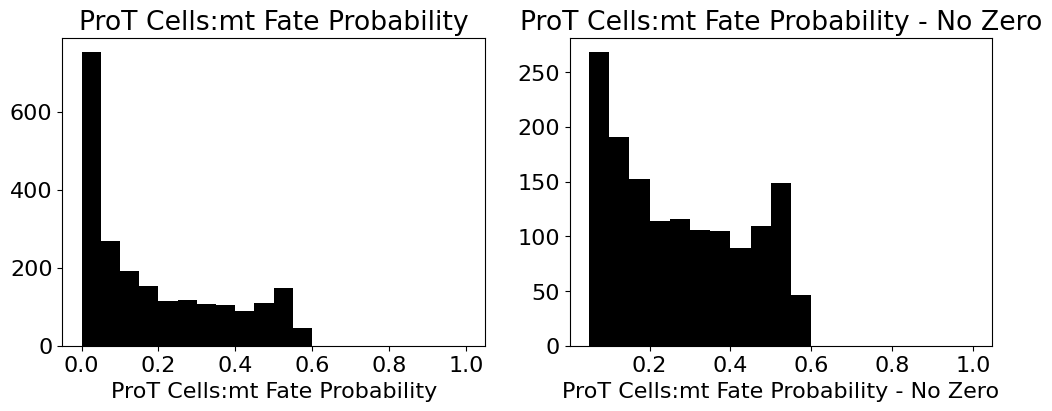

Erythroid Cells
Endpoint:  mt


C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\3433665326.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key] = fates_df[ct]


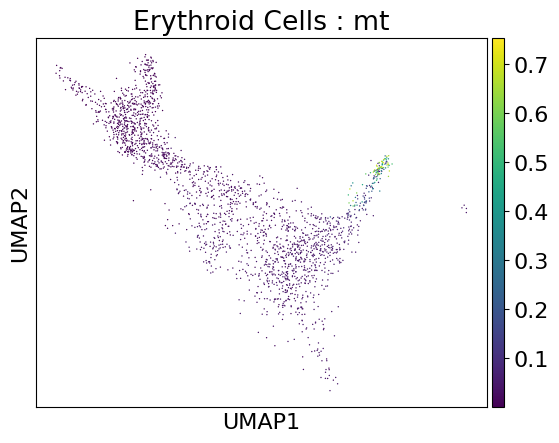

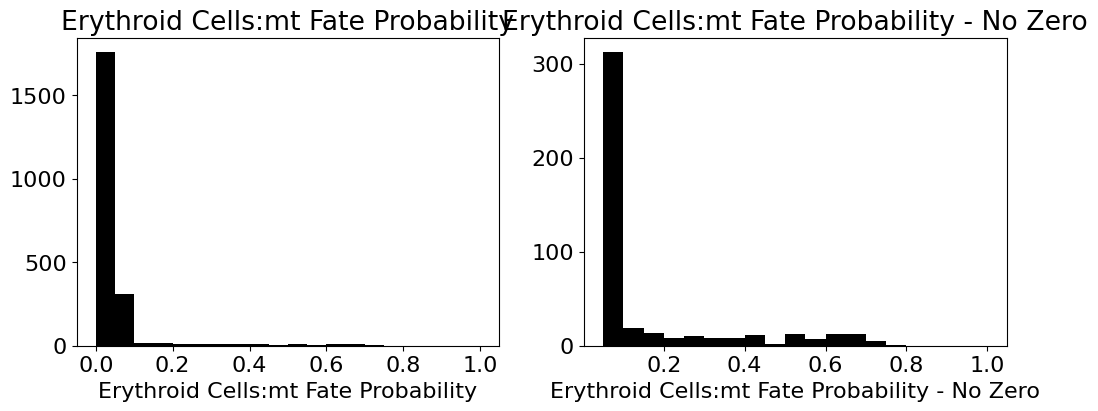

Mast Cells
Endpoint:  mt


C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\3433665326.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key] = fates_df[ct]


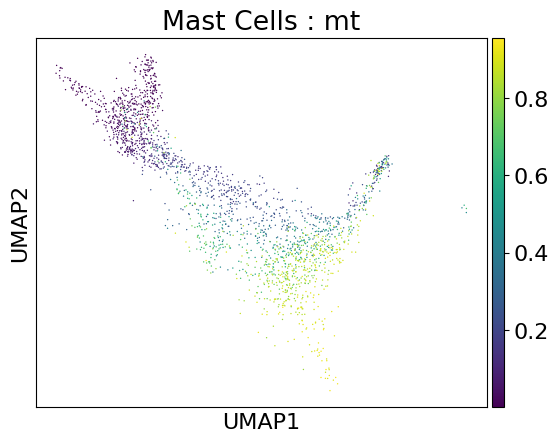

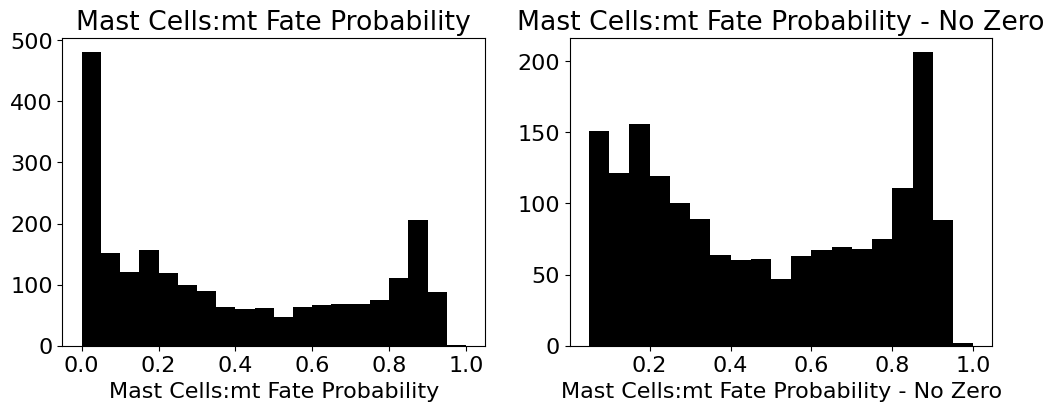

In [21]:
# T1 cells 
plot_fate_distributions_for_each_endpoint_T1_cells(ADATA_PATH, fp=FATES_PATH_NEW_GR)

C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\459290926.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = regulons[x]
C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\459290926.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = regulons[x]
C:\Users\mattc\AppData\Local\Temp\ipykernel_10852\459290926.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

           Erythroid Cells  Mast Cells  Myeloid Cells  ProT Cells  \
GATA5(+)          0.109454    0.261384       0.179692    0.064651   
TAL1(+)           0.086102    0.288237       0.241936    0.100596   
GATA1(+)          0.084973    0.455669       0.358132    0.146135   
KLF1(+)           0.081909    0.187495       0.160474    0.036296   
SOHLH2(+)         0.069905    0.121430       0.111115    0.026633   
KLF9(+)           0.060568    0.013979       0.030966    0.063757   
JUND(+)           0.035005    0.229725       0.170029    0.118399   
FOSL1(+)          0.032053    0.041029       0.021011    0.027966   
MYC(+)            0.030649    0.173022       0.182895    0.211937   
BCL6B(+)          0.029694    0.206365       0.202700    0.085958   
FOXO3(+)          0.027996    0.176518       0.274062    0.053031   
FOXP1(+)          0.027478    0.440098       0.310479    0.116274   
HIVEP1(+)         0.025773    0.215731       0.303272    0.101778   
KLF6(+)           0.025131    0.20

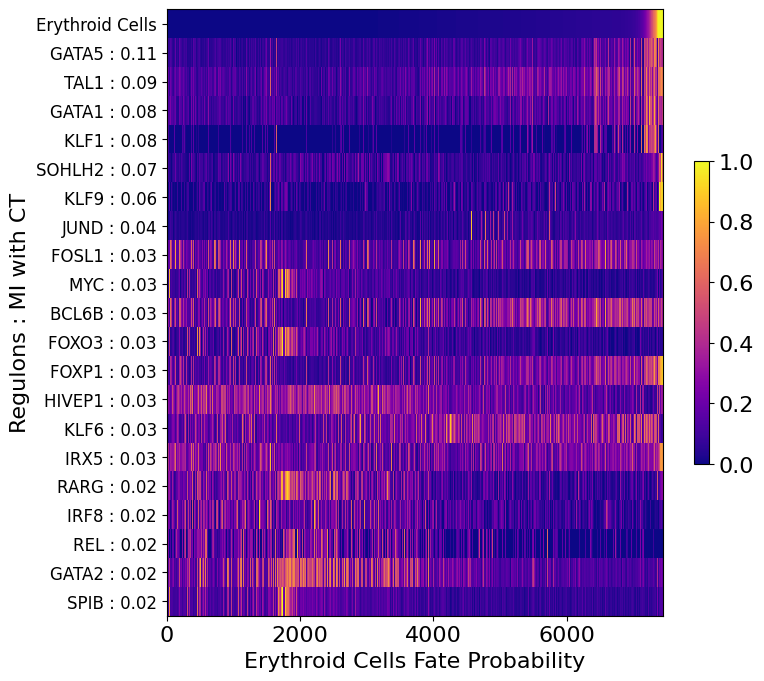

           Erythroid Cells  Mast Cells  Myeloid Cells  ProT Cells  \
GATA1(+)          0.084973    0.455669       0.358132    0.146135   
FOXP1(+)          0.027478    0.440098       0.310479    0.116274   
GATA2(+)          0.022462    0.380517       0.332882    0.109229   
TAL1(+)           0.086102    0.288237       0.241936    0.100596   
IRF8(+)           0.022732    0.282854       0.544664    0.135332   
GATA5(+)          0.109454    0.261384       0.179692    0.064651   
REL(+)            0.022616    0.240441       0.337784    0.163537   
JUND(+)           0.035005    0.229725       0.170029    0.118399   
HIVEP1(+)         0.025773    0.215731       0.303272    0.101778   
SPIB(+)           0.021835    0.214285       0.348775    0.095292   
KLF6(+)           0.025131    0.209802       0.268297    0.128575   
BCL6B(+)          0.029694    0.206365       0.202700    0.085958   
KLF1(+)           0.081909    0.187495       0.160474    0.036296   
FOXO3(+)          0.027996    0.17

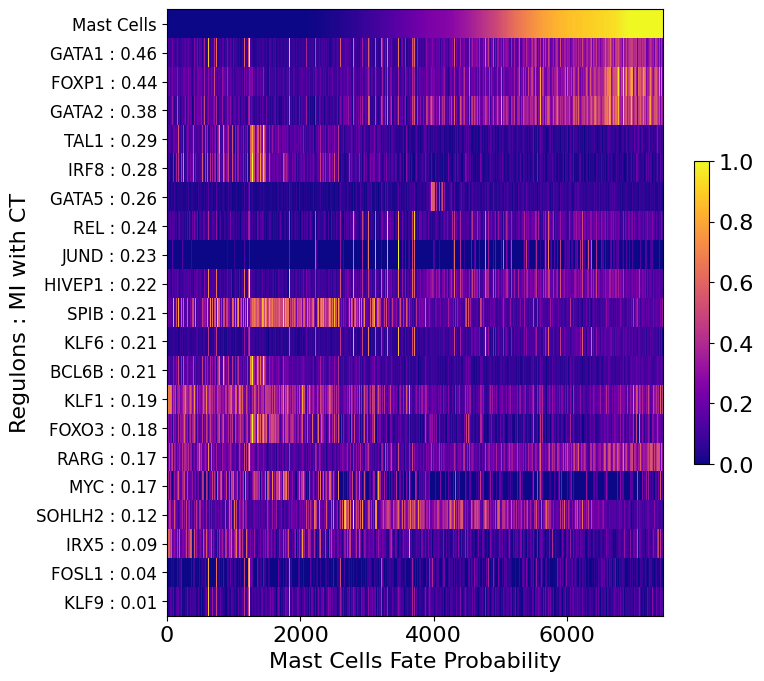

           Erythroid Cells  Mast Cells  Myeloid Cells  ProT Cells  \
IRF8(+)           0.022732    0.282854       0.544664    0.135332   
GATA1(+)          0.084973    0.455669       0.358132    0.146135   
SPIB(+)           0.021835    0.214285       0.348775    0.095292   
REL(+)            0.022616    0.240441       0.337784    0.163537   
GATA2(+)          0.022462    0.380517       0.332882    0.109229   
FOXP1(+)          0.027478    0.440098       0.310479    0.116274   
HIVEP1(+)         0.025773    0.215731       0.303272    0.101778   
FOXO3(+)          0.027996    0.176518       0.274062    0.053031   
KLF6(+)           0.025131    0.209802       0.268297    0.128575   
TAL1(+)           0.086102    0.288237       0.241936    0.100596   
BCL6B(+)          0.029694    0.206365       0.202700    0.085958   
MYC(+)            0.030649    0.173022       0.182895    0.211937   
GATA5(+)          0.109454    0.261384       0.179692    0.064651   
JUND(+)           0.035005    0.22

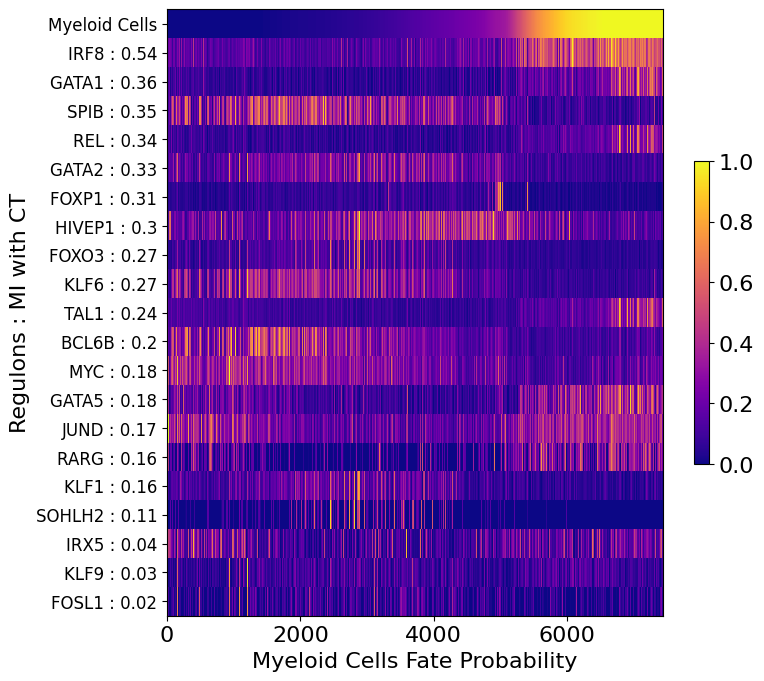

           Erythroid Cells  Mast Cells  Myeloid Cells  ProT Cells  \
MYC(+)            0.030649    0.173022       0.182895    0.211937   
REL(+)            0.022616    0.240441       0.337784    0.163537   
GATA1(+)          0.084973    0.455669       0.358132    0.146135   
IRF8(+)           0.022732    0.282854       0.544664    0.135332   
IRX5(+)           0.025067    0.089246       0.041202    0.131727   
KLF6(+)           0.025131    0.209802       0.268297    0.128575   
JUND(+)           0.035005    0.229725       0.170029    0.118399   
FOXP1(+)          0.027478    0.440098       0.310479    0.116274   
GATA2(+)          0.022462    0.380517       0.332882    0.109229   
HIVEP1(+)         0.025773    0.215731       0.303272    0.101778   
TAL1(+)           0.086102    0.288237       0.241936    0.100596   
SPIB(+)           0.021835    0.214285       0.348775    0.095292   
BCL6B(+)          0.029694    0.206365       0.202700    0.085958   
RARG(+)           0.024980    0.17

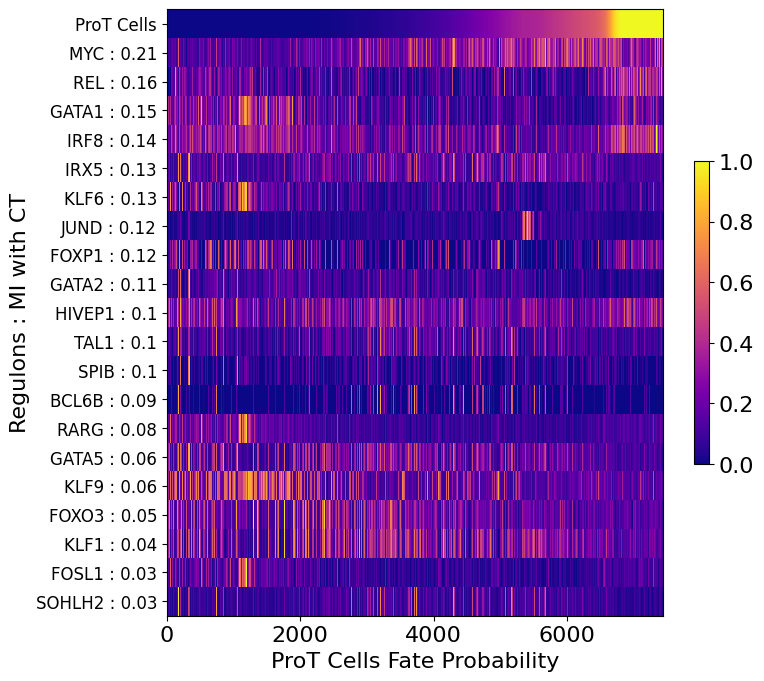

           Erythroid Cells  Mast Cells  Myeloid Cells  ProT Cells  \
IRF8(+)           0.022732    0.282854       0.544664    0.135332   
GATA2(+)          0.022462    0.380517       0.332882    0.109229   
HIVEP1(+)         0.025773    0.215731       0.303272    0.101778   
GATA1(+)          0.084973    0.455669       0.358132    0.146135   
FOXP1(+)          0.027478    0.440098       0.310479    0.116274   
KLF6(+)           0.025131    0.209802       0.268297    0.128575   
KLF1(+)           0.081909    0.187495       0.160474    0.036296   
REL(+)            0.022616    0.240441       0.337784    0.163537   
GATA5(+)          0.109454    0.261384       0.179692    0.064651   
TAL1(+)           0.086102    0.288237       0.241936    0.100596   
SPIB(+)           0.021835    0.214285       0.348775    0.095292   
SOHLH2(+)         0.069905    0.121430       0.111115    0.026633   
IRX5(+)           0.025067    0.089246       0.041202    0.131727   
MYC(+)            0.030649    0.17

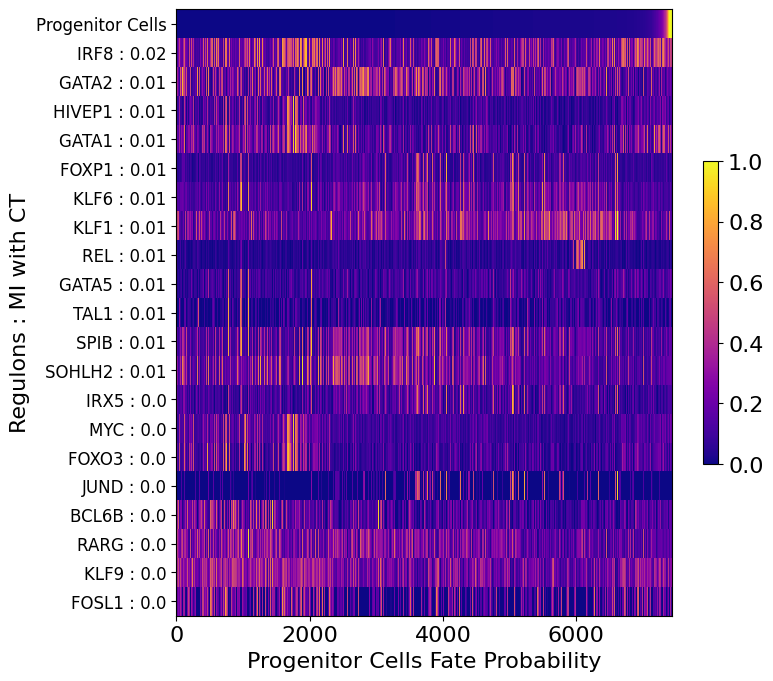

In [22]:
mi_df, df, df1 = run_mi_pipeline(REGS_PATH, FATES_PATH_NEW_GR, n_bins=10, num_regs=20, fontsize=12)

NEXT STEP: Do the same as above but exclude cells of that actual type (exclude myeloid cells for example)

In [42]:
def plot_mi_manual_order(fates_path, raw_df, discretized_df, mi_df, num_regs=15,
                         fontsize=8, save=False, lineage='Mast Cells', order=None):
    df = sc.read(fates_path).to_df()
    color_map='plasma'
    mi_df = mi_df.sort_values(by=lineage, ascending=False)[0:num_regs]
    ls = [lineage]+list(mi_df.sort_values(by=lineage, ascending=False).index)
    if order:
        order1 = [lineage]
        for j in order:
            if j.endswith('(+)'):
                order1.append(j)
            else:
                order1.append(j+'(+)')
        ls = order1

    # Make heatmap
    tmp = raw_df[ls].sort_values(by=lineage)
    s = len(tmp.columns) / 16
    x_1 = tmp.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_1)
    df_scaled = pd.DataFrame(x_scaled, columns=tmp.columns, index=tmp.index)
    y_ticks = []
    if order:
        order1 = [lineage]
        for j in order:
            if j.endswith('(+)'):
                order1.append(j)
            else:
                order1.append(j+'(+)')
        df_scaled = df_scaled[order1]
        
        y_ticks = [lineage]+[z.split('(')[0]+' : '+str(round(mi_df[lineage][z], 2)) for z in ls if z.endswith('(+)')]
    else:
        y_ticks = [lineage]+[z.split('(')[0]+' : '+str(round(mi_df[lineage][z], 2)) for z in ls if z.endswith('(+)')]
        
    with rc_context({'figure.figsize': (5.5, 5)}):
        _, ax = plt.subplots(figsize=(2 * 4, s * 6))
        img = ax.imshow(
            np.array(df_scaled.T.values),
            aspect='auto',
            interpolation='nearest',
            cmap=color_map,
        )
        plt.colorbar(img, shrink=0.5)
        plt.yticks(range(tmp.T.shape[0]),
                   y_ticks,
                   fontsize=fontsize)
        plt.ylabel('Regulons : MI with CT')
        plt.xlabel(lineage+' Fate Probability')
        plt.tight_layout()
        if save:
            plt.savefig(save, transparent=True)
        plt.show()

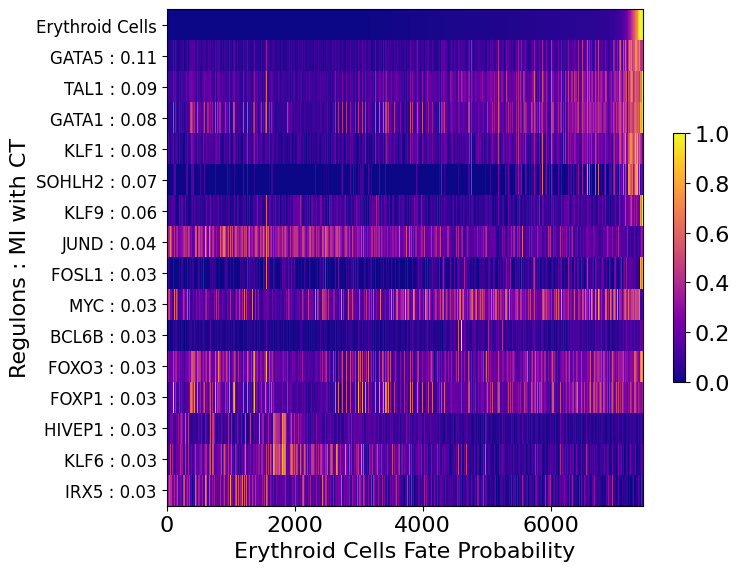

In [43]:
plot_mi_manual_order(FATES_PATH_NEW_GR, df, df1, mi_df,fontsize=12, num_regs=15,
                    lineage='Erythroid Cells',
                    order=None,
                    #save='../../data/paper-figures/MI_REGULON_VS_FATE-ERYTHROID.pdf'
                    )

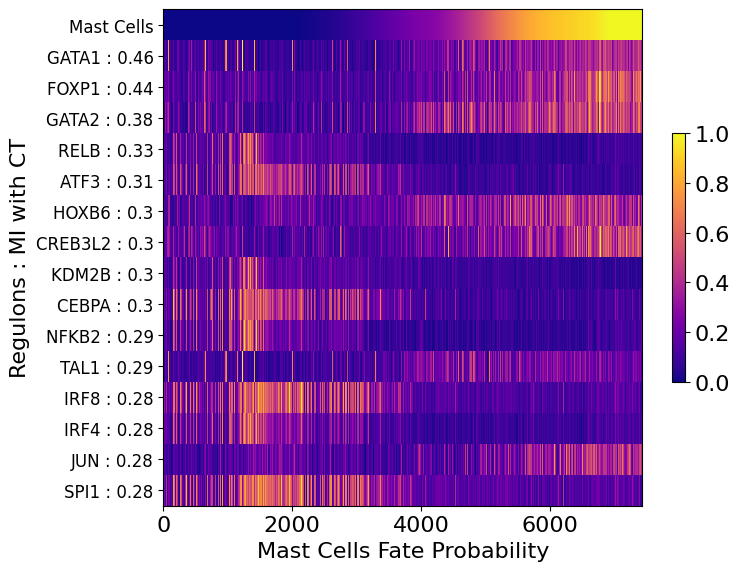

In [44]:
plot_mi_manual_order(FATES_PATH_NEW_GR, df, df1, mi_df,fontsize=12, num_regs=15,
                    lineage='Mast Cells',
                    order=None,
                    #save='../../data/paper-figures/MI_REGULON_VS_FATE-MAST.pdf'
                    )

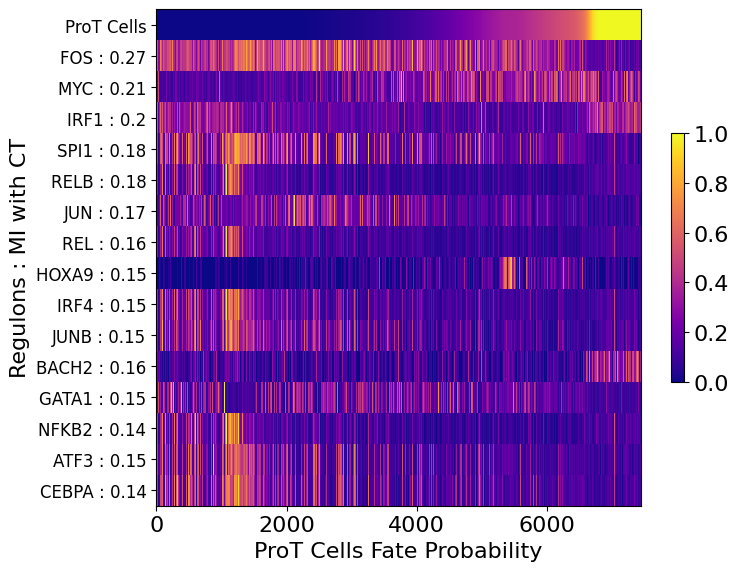

In [45]:
plot_mi_manual_order(FATES_PATH_NEW_GR, df, df1, mi_df,fontsize=12, num_regs=15,
                    lineage='ProT Cells',
                     order=['FOS','MYC', 'IRF1', 'SPI1', 'RELB', 'JUN', 'REL', 'HOXA9', 'IRF4', 'JUNB', 'BACH2', 'GATA1', 'NFKB2', 'ATF3', 'CEBPA'],
                    #save='../../data/paper-figures/MI_REGULON_VS_FATE-ProT.pdf'
                    )

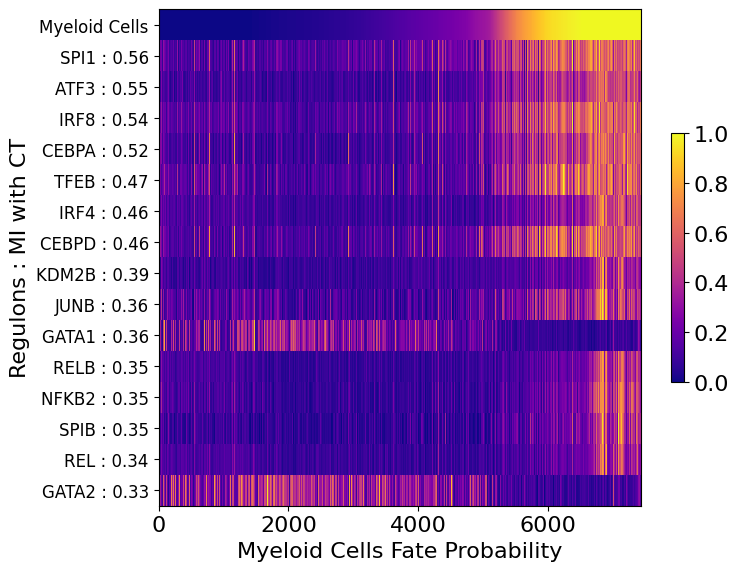

In [46]:
plot_mi_manual_order(FATES_PATH_NEW_GR, df, df1, mi_df,fontsize=12, num_regs=15,
                    lineage='Myeloid Cells',
                    order=['SPI1', 'ATF3', 'IRF8', 'CEBPA', 'TFEB', 'IRF4', 'CEBPD', 'KDM2B', 'JUNB', 'GATA1',
                          'RELB', 'NFKB2', 'SPIB', 'REL',
                           'GATA2'],
                    #save='../../data/paper-figures/MI_REGULON_VS_FATE-MYELOID.pdf'
                    )

### CDF or Histogram of MI of each of ProT mast and myeloid vs fate probability

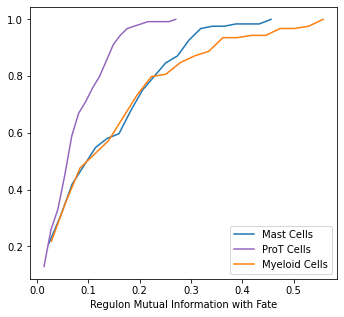

In [20]:
n_bins = 20
c_dict = {'Mast Cells':'tab:blue', 'Myeloid Cells':'tab:orange', 'ProT Cells':'tab:purple'}
with rc_context({'figure.figsize': (5.5, 5)}):
    fig, ax = plt.subplots(figsize=(5.5, 5))
    
    for lineage in ['Mast Cells', 'ProT Cells', 'Myeloid Cells']:
        count, bins_count = np.histogram(mi_df[lineage], bins=20)
        pdf = count/sum(count)
        cdf = np.cumsum(pdf)
        ax.plot(bins_count[1:], cdf, label=lineage, color=c_dict[lineage])
    
    
    ax.set_xlabel('Regulon Mutual Information with Fate')
    plt.legend()
    plt.savefig('../../data/paper-figures/Regulons_vs_FP_CDF.pdf', transparent=True)
    plt.show()

# Plot the regulons above vs timepoint

In [21]:
adata = sc.read(ADATA_PATH)

In [22]:
trajectory_ds = sc.read(FATES_PATH_NEW_GR)

In [23]:
regs = sc.read(REGS_PATH)

In [24]:
ls = []
for x in adata.obs_names:
    if x.endswith('-0'):
        ls.append(x[0:-2])
    elif x.endswith('_T1'):
        ls.append(x.split('_')[0]+'-1-0')
    else:
        ls.append(x.split('_')[0]+'-1-1')
adata.obs_names = ls

ls = []
for x in regs.obs_names:
    if x.endswith('-0'):
        ls.append(x[0:-2])
    elif x.endswith('_T1'):
        ls.append(x.split('_')[0]+'-1-0')
    else:
        ls.append(x.split('_')[0]+'-1-1')
regs.obs_names = ls

In [25]:
cell_sets = {}
for t in pd.unique(adata.obs['Cell Types']):
    cell_sets[t] = list(adata.obs.index[adata.obs['Cell Types'] == t])

In [26]:
# Load gene expression trends
trajectory_trend_datasets = []
trajectory_names = []

for i in range(trajectory_ds.shape[1]):
    trajectory_names.append(trajectory_ds.var.index[i]) 
    trajectory_trend_datasets.append(anndata.read_h5ad(REGS_TRENDS_PATH + trajectory_ds.var.index[i] + '_trends.h5ad'))

In [27]:
regs.obs['Order'] = adata.obs['Order']
regs.obs['day'] = regs.obs['Order']

In [28]:
# trajectory_trends = wot.tmap.trajectory_trends_from_trajectory(trajectory_ds, regs)

# # Save each trajectory for each type
# for i in range(len(trajectory_trends)):
#     trajectory_trends[i].write(filename = REGS_TRENDS_PATH + trajectory_ds.var.index[i] + '_trends.h5ad', compression = 'gzip')  

In [29]:
adata.uns['Cell Types_colors'] = ['tab:cyan', 'tab:red', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown']
celltype_color = dict(zip(sorted(list(set(adata.obs['Cell Types']))),
                          ['tab:cyan', 'tab:red', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown']))

def update_gene_vis(gene_names, save=None,
                    cts=['Progenitor Cells', 'Myeloid Cells', 'Erythroid Cells', 'Mast Cells', 'ProT Cells'],
                   tps={'Mast Cells':[0,14],
                       'ProT Cells':[0,14],
                       'Myeloid Cells':[0,14]}):
    n_cols = 3
    n_rows = math.ceil(len(gene_names)/n_cols)
    tp_list = list(itertools.chain(*tps.values()))
    xlim = [min(tp_list), max(tp_list)]
    with rc_context({'figure.figsize': (5.5, 5)}):

        figure = plt.figure(figsize=(10*n_cols, 10*n_rows))
        for j in range(len(gene_names)):
            plt.subplot(n_rows,n_cols,j+1)
            plt.title(gene_names[j])
            for i in range(len(trajectory_ds.var.index)):
                selected_trajectory = trajectory_ds.var.index[i]
                if selected_trajectory in cts:
                    trajectory_index = trajectory_names.index(selected_trajectory)
                    mean = trajectory_trend_datasets[trajectory_index][:, gene_names[j]]
                    tmp_ls = [str(x)+'.0' for x in range(tps[selected_trajectory][0], tps[selected_trajectory][1]+1)]
                    mean = mean[mean.obs_names.isin(tmp_ls)]
                    timepoints = mean.obs.index.values.astype(float)
                    mean.obs.index = mean.obs.index.astype('category')
                    plt.xlim(xlim)

                    plt.plot(timepoints, mean.X, c=celltype_color[selected_trajectory], label=selected_trajectory,)
                    if j == 0:
                        plt.legend()
                    plt.xlabel("Time Point")
                    plt.ylabel("Expression")
        if save:
            plt.savefig(save, transparent=True)

        plt.show()
        
def update_gene_vis_single_panel(gene_names, save=None,
                    cts=['Progenitor Cells', 'Myeloid Cells', 'Erythroid Cells', 'Mast Cells', 'ProT Cells'],
                   tps={'Mast Cells':[0,14],
                       'ProT Cells':[0,14],
                       'Myeloid Cells':[0,14]}):
    n_cols = 1
    n_rows = 1
    tp_list = list(itertools.chain(*tps.values()))
    xlim = [min(tp_list), max(tp_list)]
    with rc_context({'figure.figsize': (5.5, 5)}):

        fig, ax = plt.subplots(n_rows,n_cols, figsize=(5.5,5))
        plt.title(gene_names[0])
        for i in range(len(trajectory_ds.var.index)):
            selected_trajectory = trajectory_ds.var.index[i]
            if selected_trajectory in cts:
                trajectory_index = trajectory_names.index(selected_trajectory)
                mean = trajectory_trend_datasets[trajectory_index][:, gene_names[0]]
                tmp_ls = [str(x)+'.0' for x in range(tps[selected_trajectory][0], tps[selected_trajectory][1]+1)]
                mean = mean[mean.obs_names.isin(tmp_ls)]
                timepoints = mean.obs.index.values.astype(float)
                mean.obs.index = mean.obs.index.astype('category')
                plt.xlim(xlim)
                plt.plot(timepoints, mean.X, c=celltype_color[selected_trajectory], label=selected_trajectory,)
                plt.xlabel("Time Point")
                plt.ylabel("Expression")
        if save:
            plt.savefig(save, transparent=True)
        plt.show()

            
        
def update_gene_vis_single_smooth(gene_names, save=None,
                    cts=['Progenitor Cells', 'Myeloid Cells', 'Erythroid Cells', 'Mast Cells', 'ProT Cells'],
                   tps={'Mast Cells':[0,14],
                       'ProT Cells':[0,14],
                       'Myeloid Cells':[0,14]}, n_smooth_points=200, k=3):
    n_cols = 1
    n_rows = 1
    tp_list = list(itertools.chain(*tps.values()))
    xlim = [min(tp_list), max(tp_list)]
    with rc_context({'figure.figsize': (5.5, 5)}):

        fig, ax = plt.subplots(n_rows,n_cols, figsize=(5.5,5))
        plt.title(gene_names[0])
        for i in range(len(trajectory_ds.var.index)):
            selected_trajectory = trajectory_ds.var.index[i]
            if selected_trajectory in cts:
                trajectory_index = trajectory_names.index(selected_trajectory)
                mean = trajectory_trend_datasets[trajectory_index][:, gene_names[0]]
                tmp_ls = [str(x)+'.0' for x in range(tps[selected_trajectory][0], tps[selected_trajectory][1]+1)]
                mean = mean[mean.obs_names.isin(tmp_ls)]
                timepoints = mean.obs.index.values.astype(float)
                mean.obs.index = mean.obs.index.astype('category')
                new_timepoints = np.linspace(timepoints.min(), timepoints.max(), n_smooth_points)
                spl = make_interp_spline(timepoints, mean.X, k=k)
                power_smooth = spl(new_timepoints)
                plt.xlim(xlim)
                plt.plot(new_timepoints, power_smooth, c=celltype_color[selected_trajectory], label=selected_trajectory,)
                plt.xticks(ticks=timepoints, labels=timepoints)
                plt.xlabel("Time Point")
                plt.ylabel("Expression")
        if save:
            plt.savefig(save, transparent=True)
        plt.show()


In [30]:
for i in trajectory_trend_datasets:
    ls = []
    for x in i.var_names:
        ls.append(x.split('(+)')[0])
    i.var_names = ls

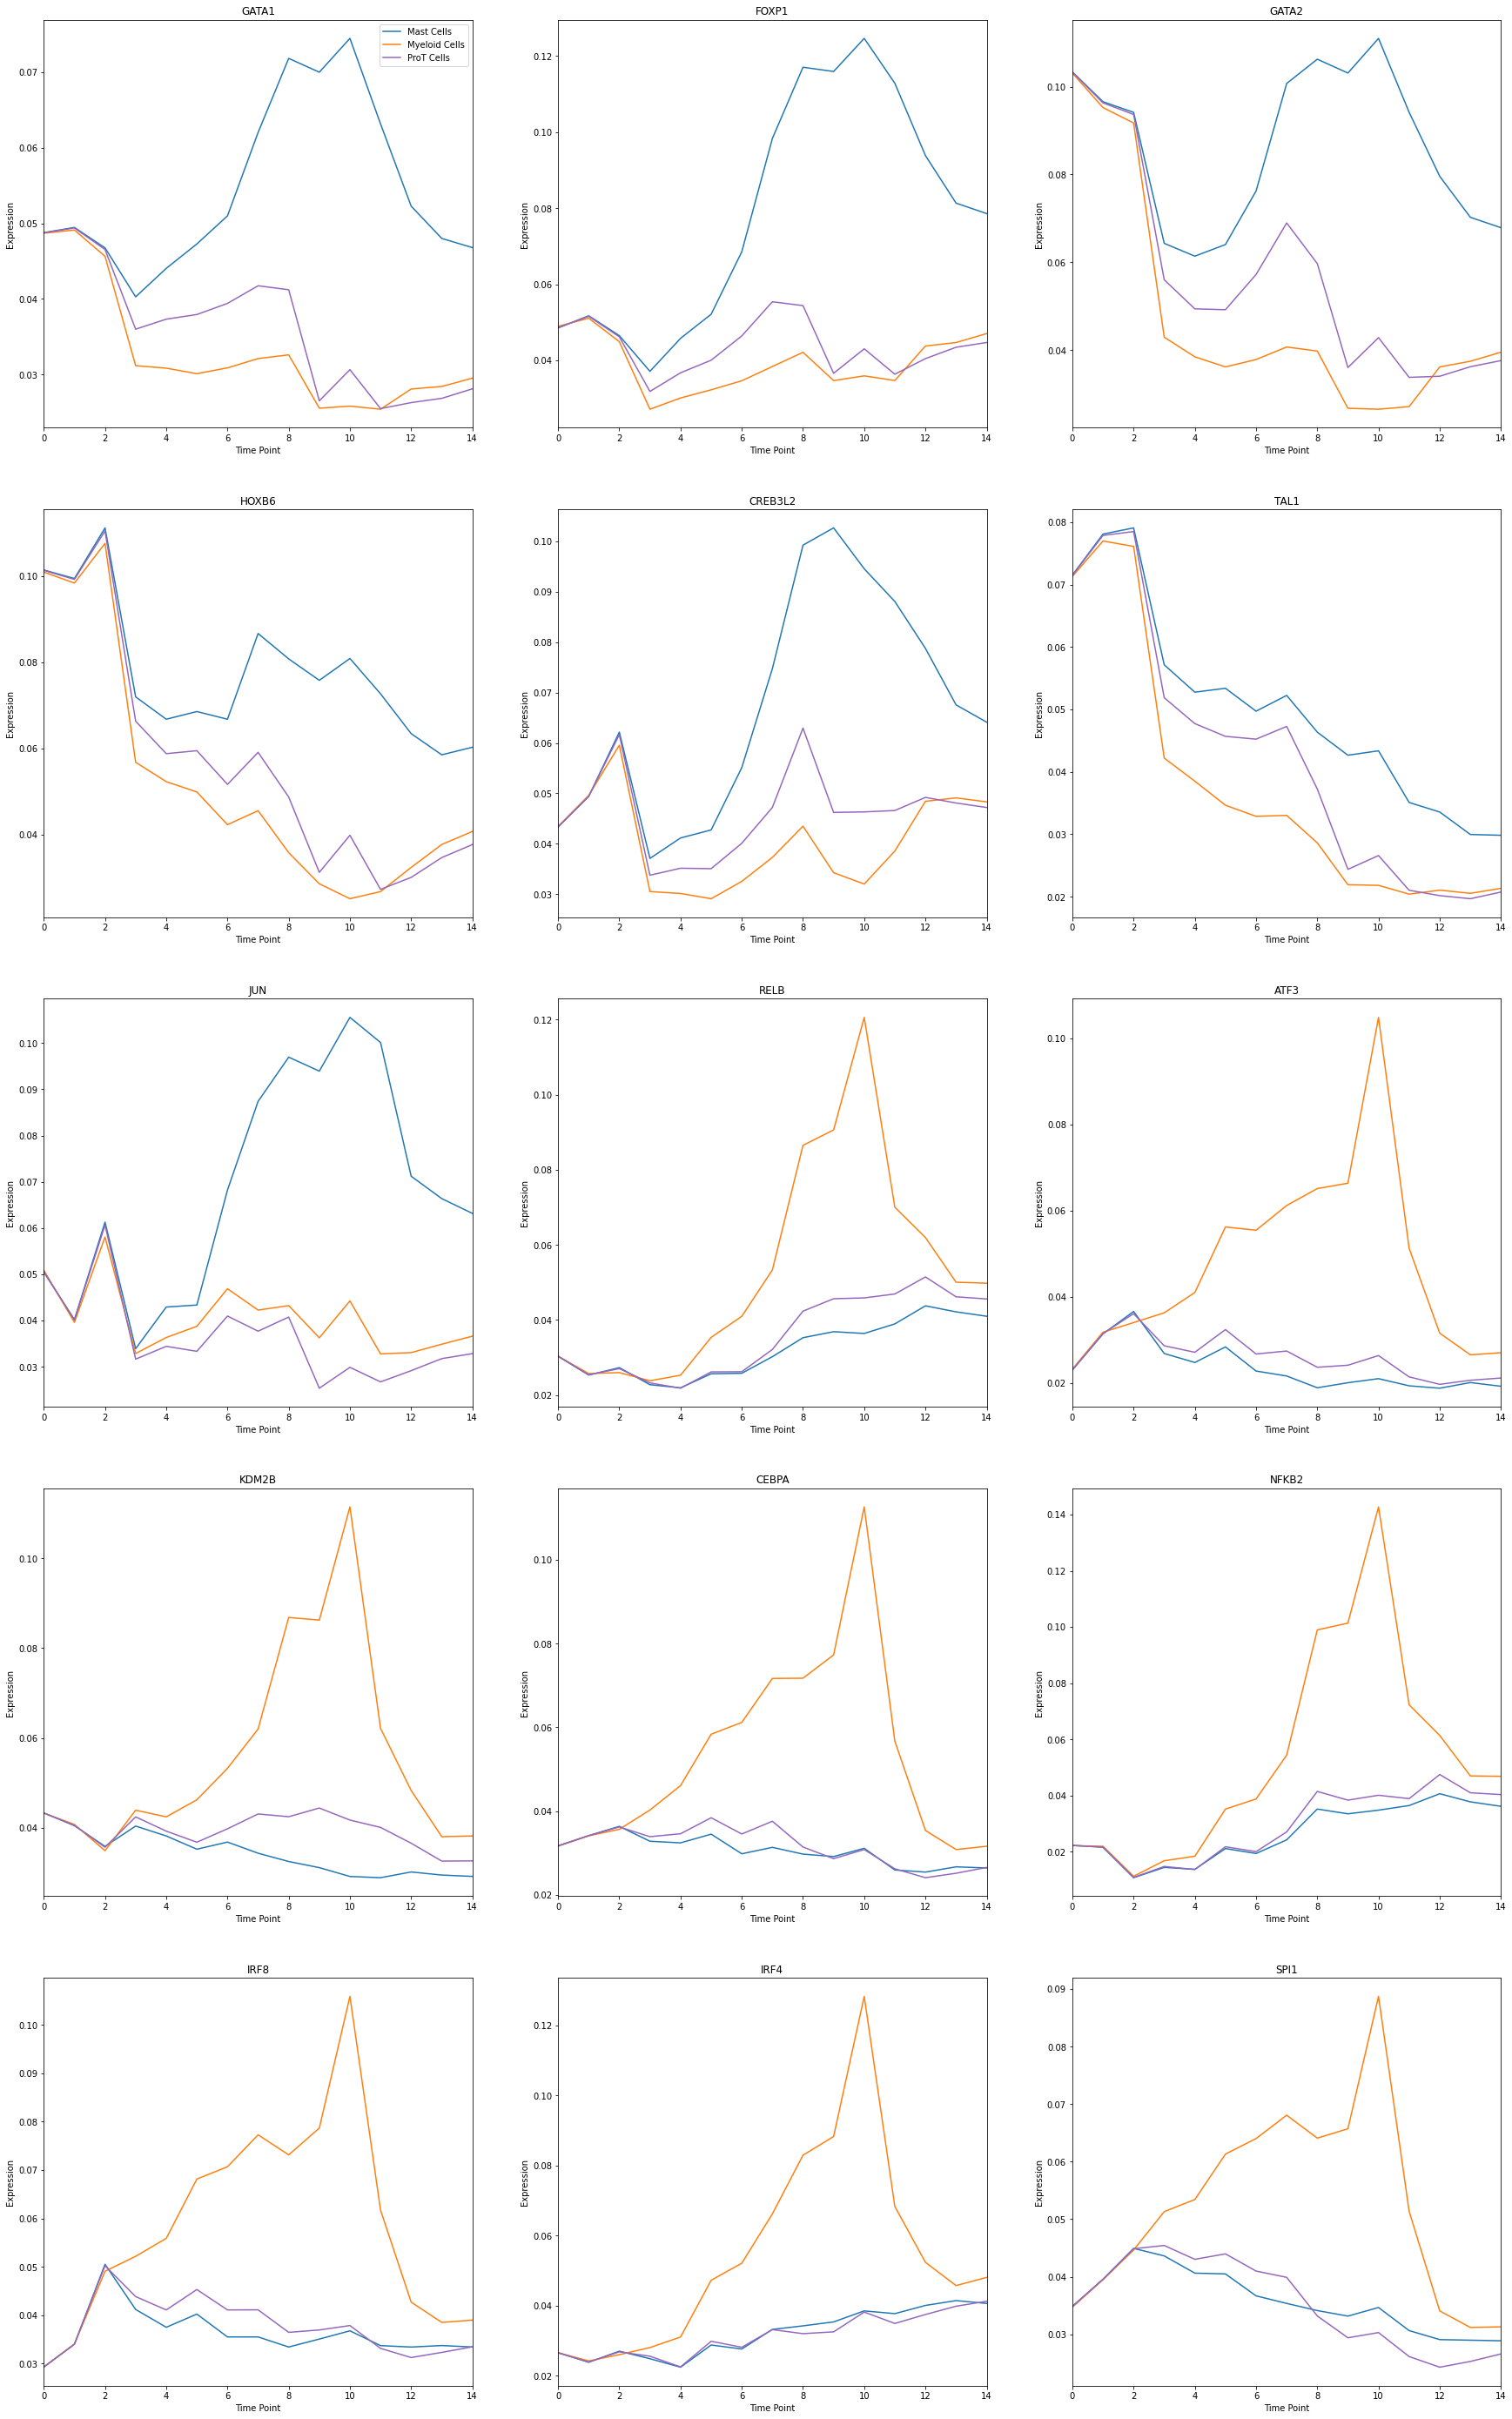

In [31]:
mast = ['GATA1', 'FOXP1', 'GATA2', 'HOXB6', 'CREB3L2', 'TAL1', 'JUN',
      'RELB', 'ATF3', 'KDM2B', 'CEBPA', 'NFKB2', 'IRF8', 'IRF4', 'SPI1']
prot = ['MYC', 'HOXA9', 'BACH2',
 'FOS', 'IRF1', 'RELB', 'SPI1', 'JUN', 'REL', 'IRF4', 'JUNB', 'ATF3', 'GATA1', 'NFKB2','CEBPA']
mye = ['SPI1', 'ATF3', 'IRF8', 'CEBPA', 'TFEB', 'CEBPD', 'IRF4', 'KDM2B', 'JUNB',
       'RELB', 'NFKB2', 'SPIB', 'REL',
       'GATA1', 'GATA2']

total = list(set(mast+prot+mye))

update_gene_vis(gene_names=mast,
                save=None,
                tps={'Mast Cells':[0,14],
                       'ProT Cells':[0,14],
                       'Myeloid Cells':[0,14]},
                cts=['Myeloid Cells', 'Mast Cells', 'ProT Cells'])

In [32]:
reg_vs_tp_dir = '../../data/paper-figures/regulon_vs_timepoint/'
if not os.path.isdir(reg_vs_tp_dir):
    os.mkdir(reg_vs_tp_dir)

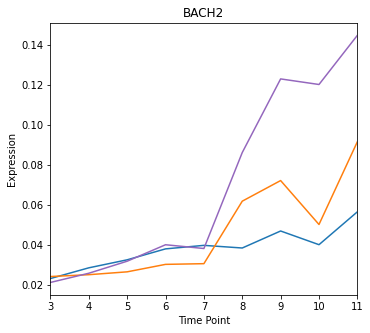

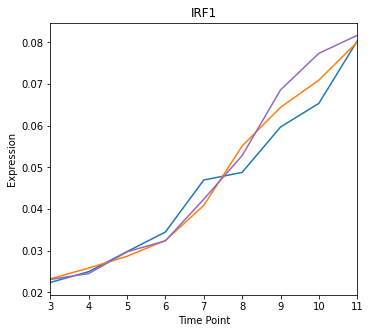

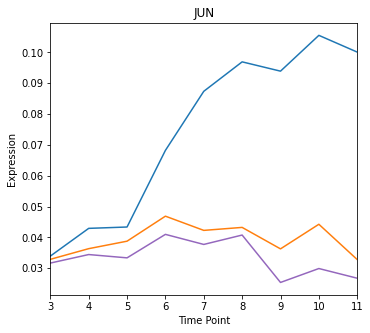

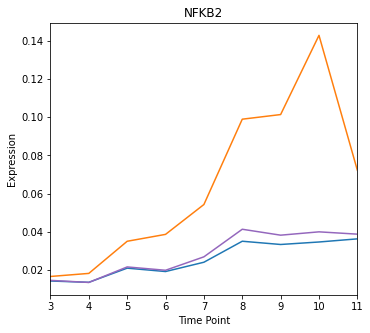

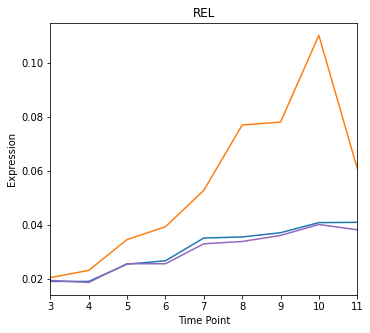

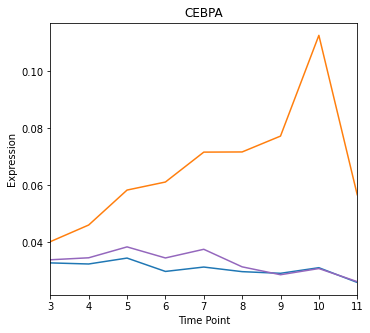

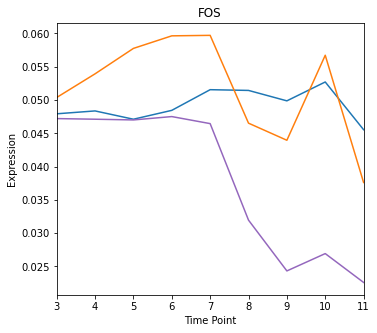

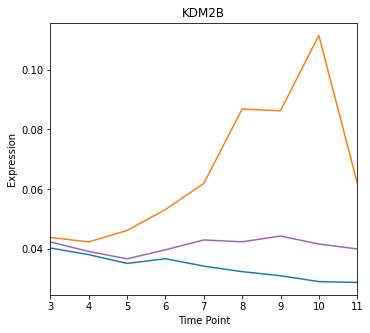

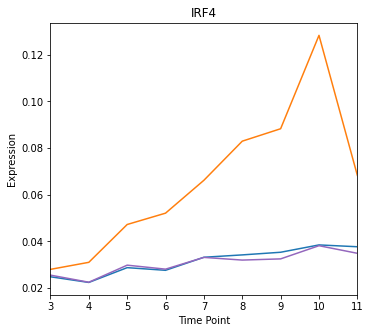

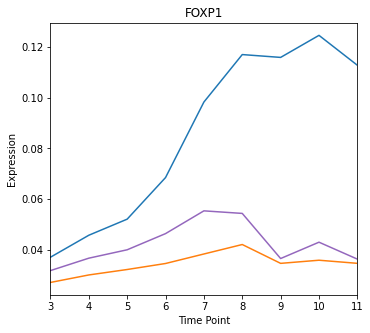

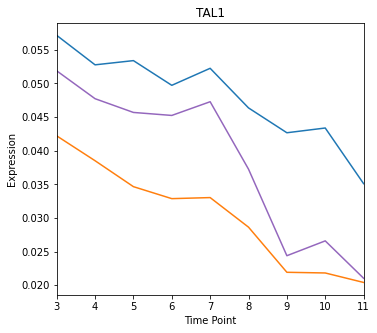

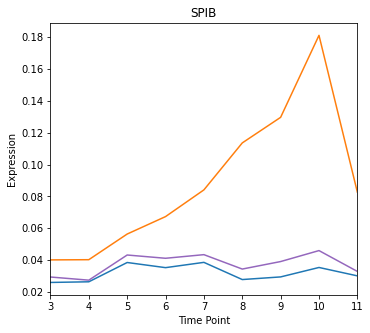

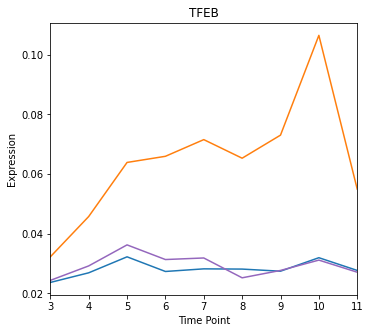

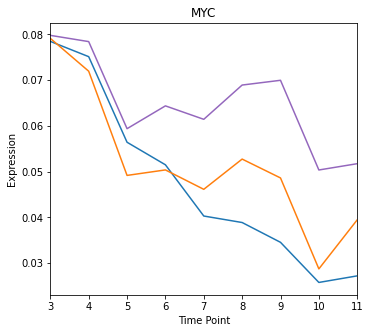

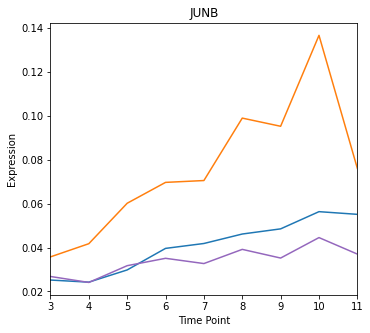

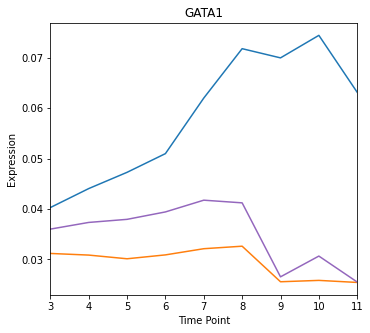

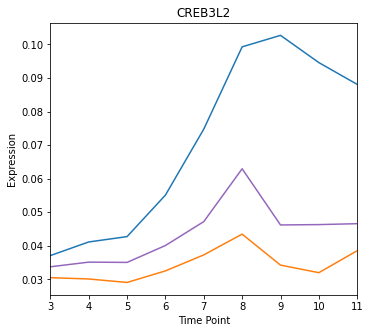

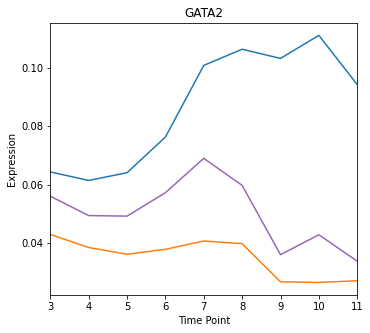

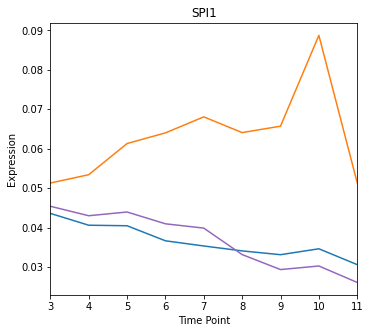

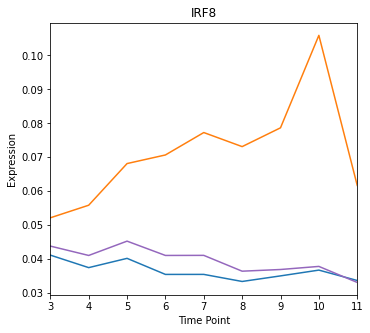

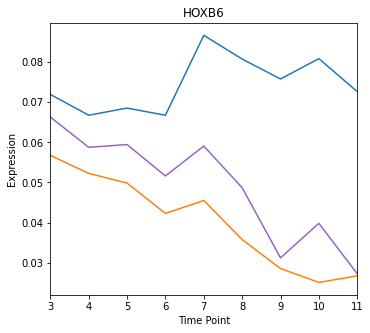

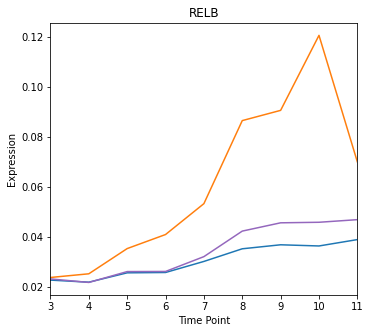

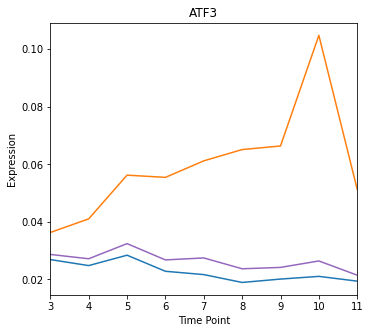

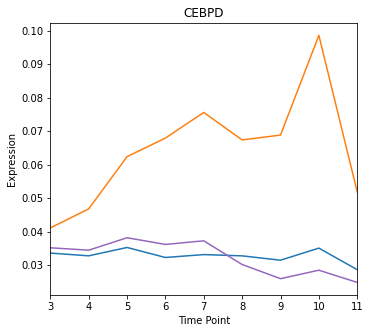

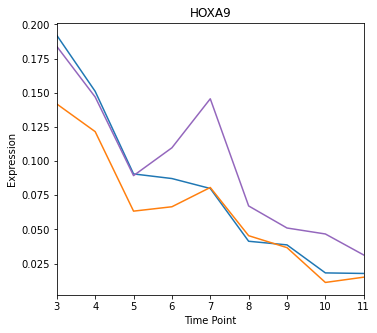

In [33]:
tps={'Mast Cells':[3,11],
     'ProT Cells':[3,11],
     'Myeloid Cells':[3,11]}
for gene in total:
    update_gene_vis_single_panel(gene_names=[gene],
                    save=reg_vs_tp_dir+'reg_vs_tp_'+gene+'.pdf',
                    tps = tps,
                    cts=['Myeloid Cells', 'Mast Cells', 'ProT Cells'])
    

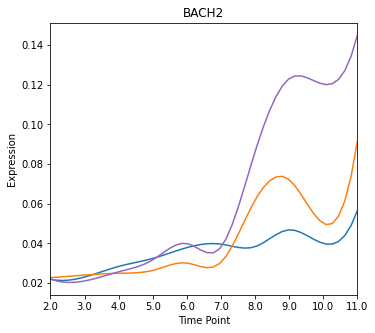

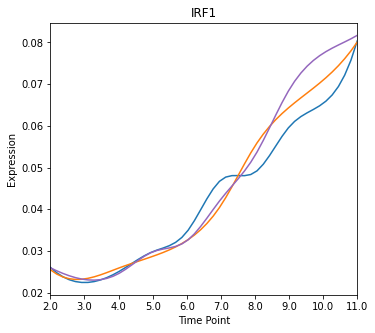

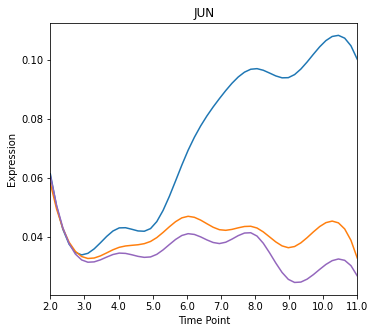

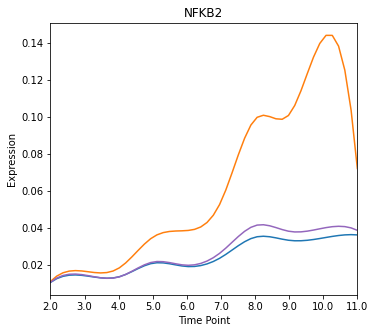

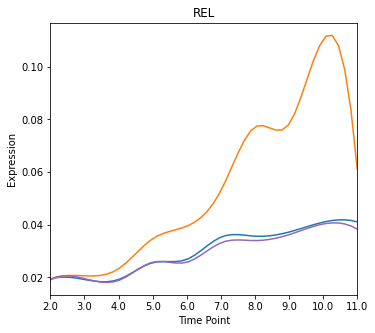

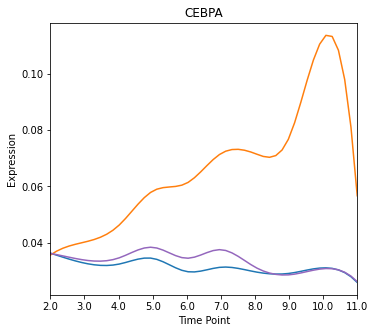

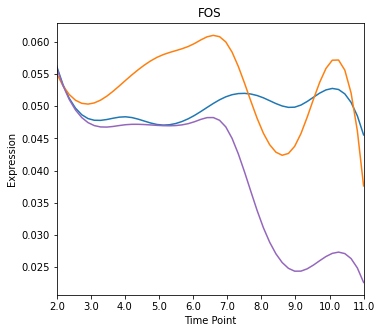

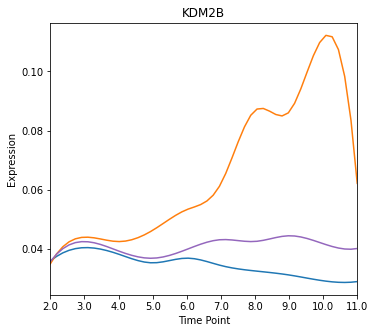

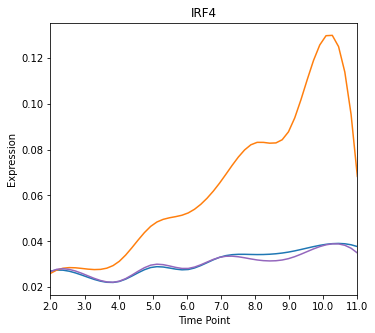

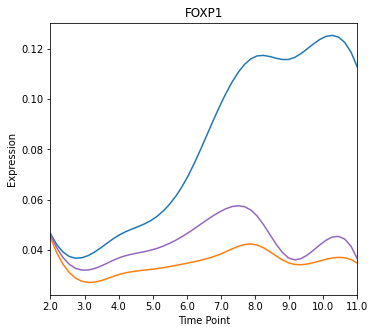

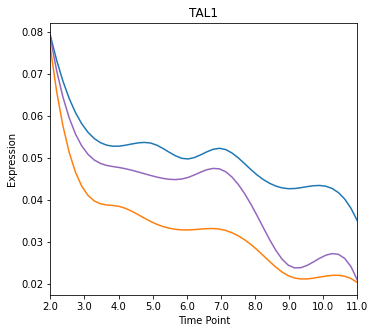

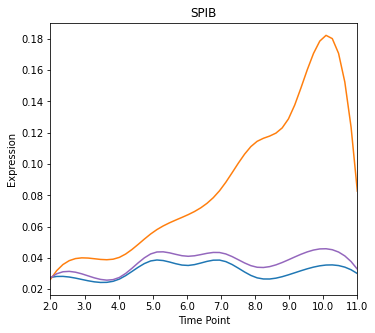

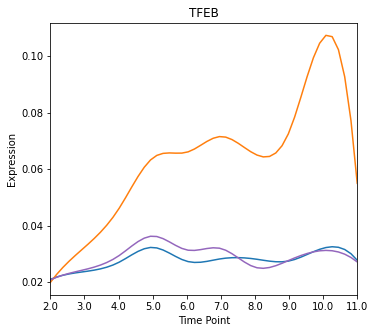

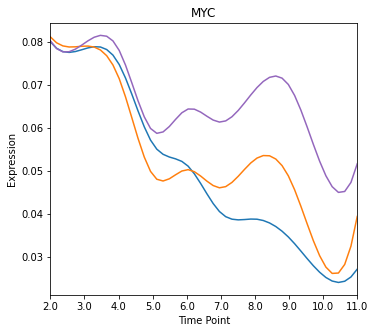

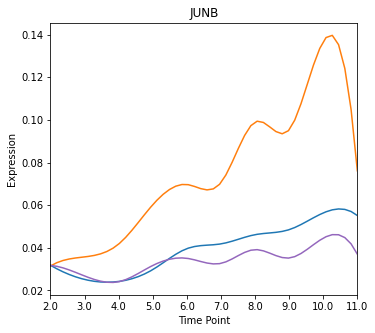

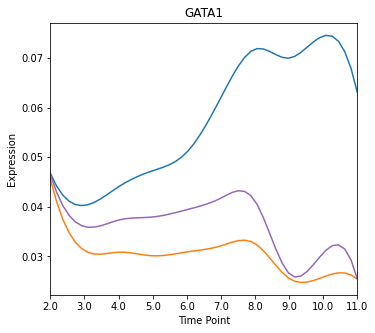

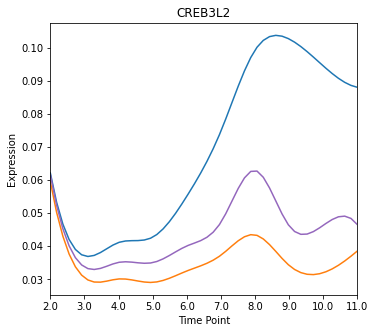

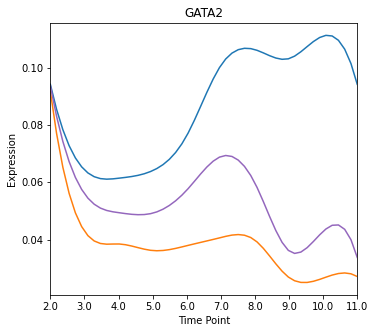

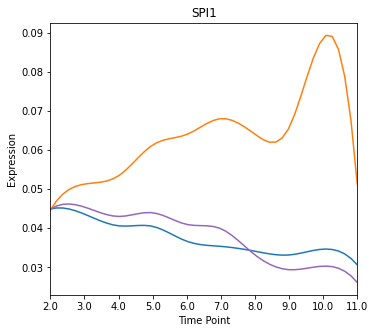

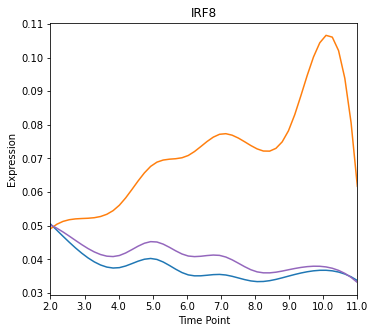

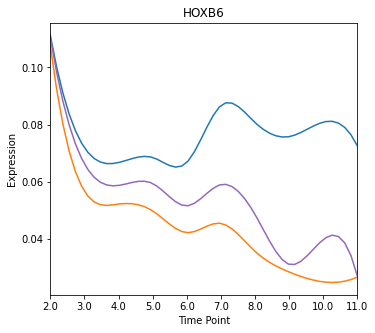

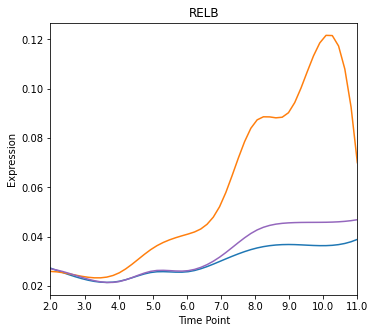

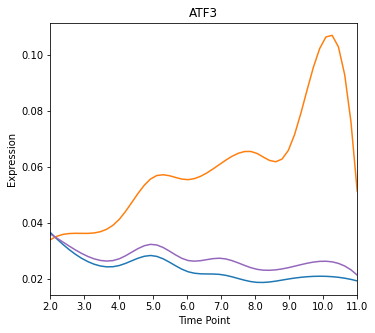

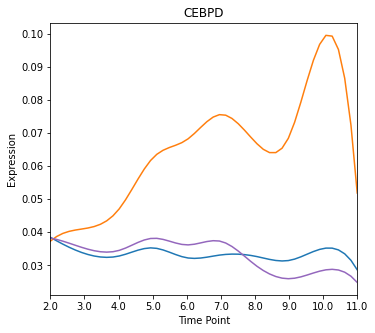

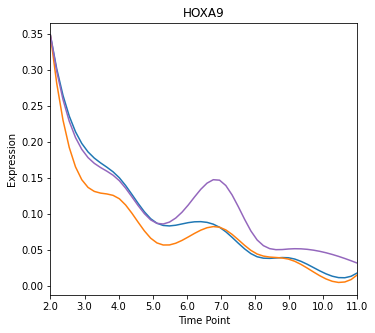

In [34]:
tps={'Mast Cells':[2,11],
     'ProT Cells':[2,11],
     'Myeloid Cells':[2,11]}
for gene in total:
    update_gene_vis_single_smooth(gene_names=[gene],
                    save=reg_vs_tp_dir+'reg_vs_tp_'+gene+'smooth.pdf',
                    tps = tps,
                    cts=['Myeloid Cells', 'Mast Cells', 'ProT Cells'],
                                 n_smooth_points=50,
                                 k=3)

In [121]:
short_list = ['GATA1', 'GATA2','FOXP1','SPI1', 'ATF3', 'IRF8','MYC','BACH2']

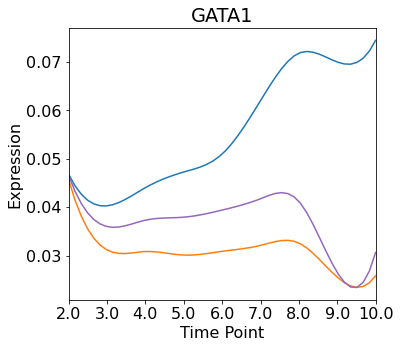

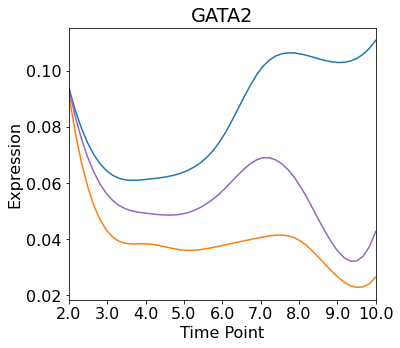

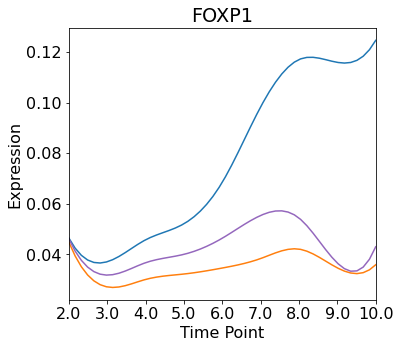

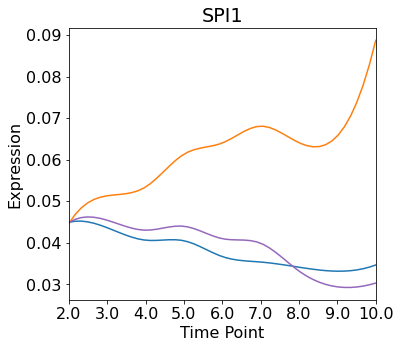

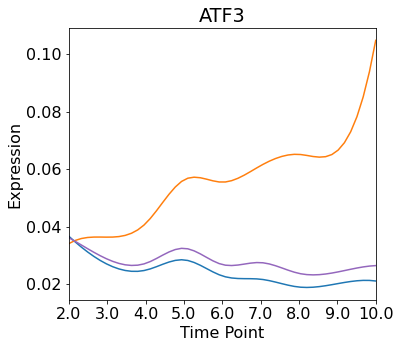

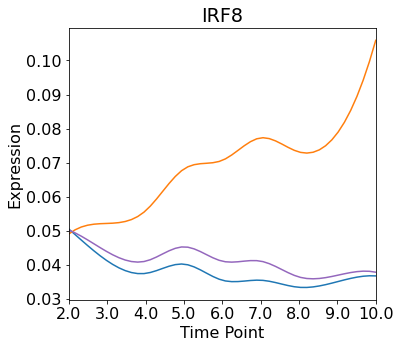

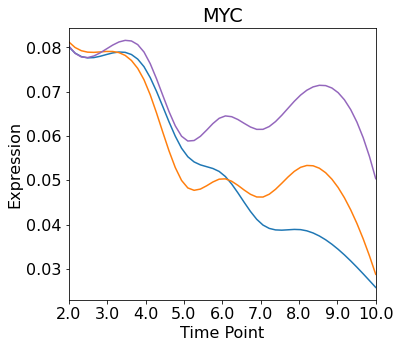

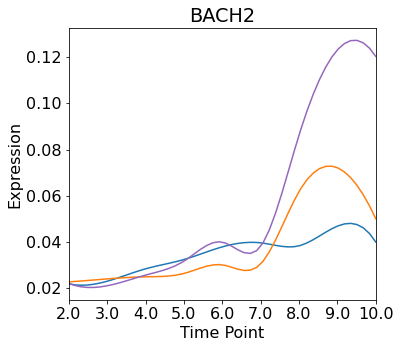

In [127]:
tps={'Mast Cells':[2,10],
     'ProT Cells':[2,10],
     'Myeloid Cells':[2,10]}
for gene in short_list:
    update_gene_vis_single_smooth(gene_names=[gene],
                    save=reg_vs_tp_dir+'reg_vs_tp_'+gene+'smooth.pdf',
                    tps = tps,
                    cts=['Myeloid Cells', 'Mast Cells', 'ProT Cells'],
                                 n_smooth_points=50,
                                 k=3)

In [35]:
# View cells per timepoint in each linegae for this dataset (combined dataset)
df = adata.obs[['Order', 'Cell Types']]
df[df['Cell Types']=='Mast Cells'].groupby('Order').count()

,Cell Types
Order,
4,2
5,77
6,33
7,30
8,182
9,148
10,1626
11,124
12,76
